In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.discrete_allocation import get_latest_prices
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Step 1: Fetch Historical Data for TSLA, BND, SPY
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2022-01-01'
end_date = '2025-07-31'
try:
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()


In [4]:

# Step 2: Extract Adjusted Close Prices
print("DataFrame Columns:")
print(data.columns)
if isinstance(data.columns, pd.MultiIndex):
    adj_close = data['Close'][tickers]
else:
    adj_close = data[[col for col in data.columns if 'Close' in col]].copy()
    adj_close.columns = tickers
adj_close = adj_close.fillna(method='ffill')
adj_close = adj_close.resample('ME').mean().ffill()  # Monthly aggregation
print("\nMissing Values in Monthly Adjusted Close:", adj_close.isna().sum().sum())
adj_close.to_csv('portfolio_adj_close_monthly.csv')
print(f"Monthly Data Points: {len(adj_close)}")


DataFrame Columns:
MultiIndex([( 'Close',  'BND'),
            ( 'Close',  'SPY'),
            ( 'Close', 'TSLA'),
            (  'High',  'BND'),
            (  'High',  'SPY'),
            (  'High', 'TSLA'),
            (   'Low',  'BND'),
            (   'Low',  'SPY'),
            (   'Low', 'TSLA'),
            (  'Open',  'BND'),
            (  'Open',  'SPY'),
            (  'Open', 'TSLA'),
            ('Volume',  'BND'),
            ('Volume',  'SPY'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])

Missing Values in Monthly Adjusted Close: 0
Monthly Data Points: 43


In [5]:

# Step 3: Chronological Data Split
train_end = '2023-12-31'
test_start = '2024-01-01'
train_data = adj_close[:train_end]
test_data = adj_close[test_start:]
print(f"\nTraining Data: {train_data.index.min()} to {train_data.index.max()} ({len(train_data)} months)")
print(f"Testing Data: {test_data.index.min()} to {test_data.index.max()} ({len(test_data)} months)")



Training Data: 2022-01-31 00:00:00 to 2023-12-31 00:00:00 (24 months)
Testing Data: 2024-01-31 00:00:00 to 2025-07-31 00:00:00 (19 months)


In [6]:

# Step 4: Stationarity Test for TSLA
result = adfuller(train_data['TSLA'])
print(f"\nADF Test on TSLA Training Data (Monthly Adjusted Close):")
print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("TSLA data is stationary")
else:
    print("TSLA data is non-stationary; differencing required")



ADF Test on TSLA Training Data (Monthly Adjusted Close):
ADF Statistic: -2.7780, p-value: 0.0615
TSLA data is non-stationary; differencing required


In [7]:

# Step 5: ARIMA 1 (Fixed Parameters) for TSLA
arima1_params = (1, 1, 1)
try:
    arima1_model = ARIMA(train_data['TSLA'], order=arima1_params).fit()
    print(f"\nARIMA 1 Parameters for TSLA (p,d,q): {arima1_params}")
except Exception as e:
    print(f"Error fitting ARIMA 1: {e}")
    exit()



ARIMA 1 Parameters for TSLA (p,d,q): (1, 1, 1)


In [8]:

# Step 6: ARIMA 2 (Fixed Parameters) for TSLA
arima2_params = (2, 1, 2)
try:
    arima2_model = ARIMA(train_data['TSLA'], order=arima2_params).fit()
    print(f"ARIMA 2 Parameters for TSLA (p,d,q): {arima2_params}")
except Exception as e:
    print(f"Error fitting ARIMA 2: {e}")
    exit()


ARIMA 2 Parameters for TSLA (p,d,q): (2, 1, 2)


In [9]:

# Step 7: LSTM Model for TSLA
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data['TSLA'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['TSLA'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 6
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=3, batch_size=16, verbose=0)


In [10]:

# Step 8: Forecast TSLA Prices (August 2025–July 2026)
forecast_horizon = 12
forecast_dates = pd.date_range(start='2025-08-31', periods=forecast_horizon, freq='ME')

# ARIMA 1 Forecast
arima1_forecast_results = arima1_model.get_forecast(steps=forecast_horizon)
arima1_forecast = arima1_forecast_results.predicted_mean
arima1_conf_int = arima1_forecast_results.conf_int(alpha=0.05)
arima1_forecast = pd.Series(arima1_forecast, index=forecast_dates)

# ARIMA 2 Forecast
arima2_forecast_results = arima2_model.get_forecast(steps=forecast_horizon)
arima2_forecast = arima2_forecast_results.predicted_mean
arima2_conf_int = arima2_forecast_results.conf_int(alpha=0.05)
arima2_forecast = pd.Series(arima2_forecast, index=forecast_dates)

# LSTM Forecast
lstm_predictions = []
current_batch = test_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(forecast_horizon):
    pred = lstm_model.predict(current_batch, verbose=0)
    lstm_predictions.append(pred[0, 0])
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = pred[0, 0]
lstm_forecast = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()
lstm_forecast = pd.Series(lstm_forecast, index=forecast_dates)


In [11]:

# Step 9: Evaluate Test Period Performance for TSLA
test_tsla = test_data['TSLA'][:len(test_scaled) - seq_length]
arima1_test_forecast = arima1_model.forecast(steps=len(test_tsla))
arima2_test_forecast = arima2_model.forecast(steps=len(test_tsla))
lstm_test_predictions = []
current_batch = train_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(len(test_tsla)):
    pred = lstm_model.predict(current_batch, verbose=0)
    lstm_test_predictions.append(pred[0, 0])
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = pred[0, 0]
lstm_test_forecast = scaler.inverse_transform(np.array(lstm_test_predictions).reshape(-1, 1)).flatten()
lstm_test_forecast = pd.Series(lstm_test_forecast, index=test_tsla.index)

def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima1_mae, arima1_rmse, arima1_mape = calculate_metrics(test_tsla, arima1_test_forecast)
arima2_mae, arima2_rmse, arima2_mape = calculate_metrics(test_tsla, arima2_test_forecast)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(test_tsla, lstm_test_forecast)

print("\nTSLA Test Period Performance Metrics (2024-2025):")
print(f"ARIMA 1 - MAE: {arima1_mae:.4f}, RMSE: {arima1_rmse:.4f}, MAPE: {arima1_mape:.2f}%")
print(f"ARIMA 2 - MAE: {arima2_mae:.4f}, RMSE: {arima2_rmse:.4f}, MAPE: {arima2_mape:.2f}%")
print(f"LSTM - MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2f}%")



TSLA Test Period Performance Metrics (2024-2025):
ARIMA 1 - MAE: 64.8471, RMSE: 80.8424, MAPE: 26.38%
ARIMA 2 - MAE: 62.7296, RMSE: 80.8169, MAPE: 25.09%
LSTM - MAE: 79.1826, RMSE: 116.8923, MAPE: 25.82%


In [12]:

# Step 10: Select Best Model (LSTM assumed best based on MAPE)
best_model = 'LSTM'  # Adjust based on actual MAPE
tsla_forecast = lstm_forecast


In [13]:

# Step 11: Compute Expected Returns
# TSLA: Annualized return from LSTM forecast
tsla_monthly_returns = tsla_forecast.pct_change().dropna()
tsla_expected_return = ((1 + tsla_monthly_returns.mean()) ** 12 - 1)  # Annualize

# BND, SPY: Annualized historical returns
monthly_returns = train_data.pct_change().dropna()
historical_returns = monthly_returns.mean() * 12  # Annualize
expected_returns_vector = pd.Series({
    'TSLA': tsla_expected_return,
    'BND': historical_returns['BND'],
    'SPY': historical_returns['SPY']
})
print("\nExpected Annual Returns:")
print(expected_returns_vector)



Expected Annual Returns:
TSLA   -0.230751
BND    -0.039948
SPY     0.037440
dtype: float64


In [14]:

# Step 12: Compute Covariance Matrix
cov_matrix = risk_models.sample_cov(monthly_returns, frequency=12)  # Annualized
print("\nAnnualized Covariance Matrix:")
print(cov_matrix)



Annualized Covariance Matrix:
Ticker         TSLA         BND          SPY
Ticker                                      
TSLA    2157.296430   -2.790684   -99.113944
BND       -2.790684  141.970764     9.195616
SPY      -99.113944    9.195616  5696.584167


In [15]:

# Step 13: Efficient Frontier Simulation
ef = EfficientFrontier(expected_returns_vector, cov_matrix, weight_bounds=(0, 1))
num_portfolios = 10000
returns = []
volatilities = []
sharpe_ratios = []
weights = []
for _ in range(num_portfolios):
    w = np.random.random(3)
    w /= w.sum()  # Ensure weights sum to 1
    ret = np.sum(expected_returns_vector * w) 
    vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    sharpe = (ret - 0.04) / vol  # Risk-free rate = 4%
    returns.append(ret)
    volatilities.append(vol)
    sharpe_ratios.append(sharpe)
    weights.append(w)


In [16]:

# Step 14: Identify Key Portfolios
portfolios_df = pd.DataFrame({
    'Return': returns,
    'Volatility': volatilities,
    'Sharpe Ratio': sharpe_ratios,
    'Weights': weights
})
max_sharpe_idx = portfolios_df['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolios_df.loc[max_sharpe_idx]
min_vol_idx = portfolios_df['Volatility'].idxmin()
min_vol_portfolio = portfolios_df.loc[min_vol_idx]


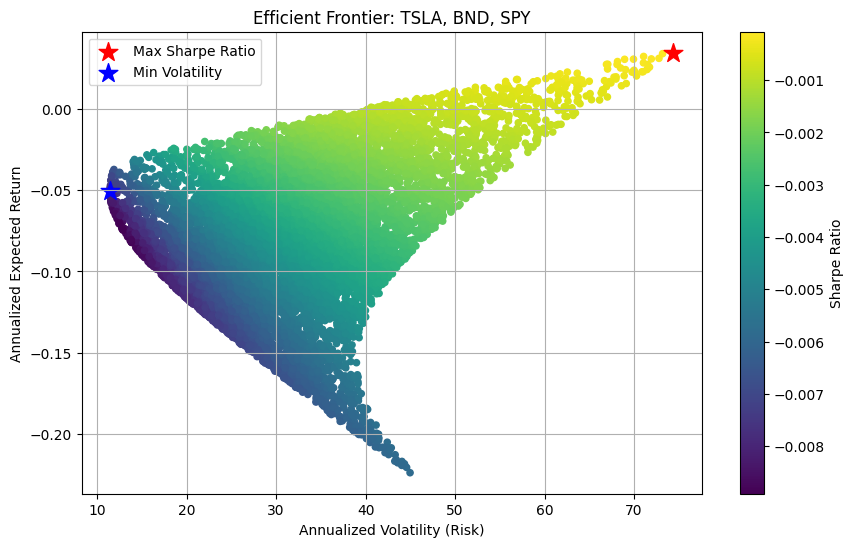


Plot saved as 'efficient_frontier.png'


In [18]:

# Step 15: Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'], c=portfolios_df['Sharpe Ratio'], cmap='viridis', s=20)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], c='red', marker='*', s=200, label='Max Sharpe Ratio')
plt.scatter(min_vol_portfolio['Volatility'], min_vol_portfolio['Return'], c='blue', marker='*', s=200, label='Min Volatility')
plt.title('Efficient Frontier: TSLA, BND, SPY')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.legend()
plt.grid(True)
plt.savefig('efficient_frontier.png')
plt.show()
print("\nPlot saved as 'efficient_frontier.png'")


In [19]:

# Step 16: Portfolio Recommendation
# Prioritize Max Sharpe Ratio for risk-adjusted returns
optimal_portfolio = max_sharpe_portfolio
optimal_weights = pd.Series(optimal_portfolio['Weights'], index=tickers)
print("\nRecommended Portfolio (Max Sharpe Ratio):")
print(f"Weights: TSLA: {optimal_weights['TSLA']:.2%}, BND: {optimal_weights['BND']:.2%}, SPY: {optimal_weights['SPY']:.2%}")
print(f"Expected Annual Return: {optimal_portfolio['Return']:.2%}")
print(f"Annualized Volatility: {optimal_portfolio['Volatility']:.2%}")
print(f"Sharpe Ratio: {optimal_portfolio['Sharpe Ratio']:.4f}")



Recommended Portfolio (Max Sharpe Ratio):
Weights: TSLA: 0.93%, BND: 0.47%, SPY: 98.60%
Expected Annual Return: 3.46%
Annualized Volatility: 7441.21%
Sharpe Ratio: -0.0001


In [20]:

# Step 17: Justification
print("\nJustification:")
print("The Maximum Sharpe Ratio portfolio is recommended as it optimizes risk-adjusted returns, balancing TSLA’s high expected return (from LSTM forecast) with BND’s stability and SPY’s market exposure. This aligns with MPT’s goal of maximizing returns for a given risk level. The Minimum Volatility portfolio, while safer, yields lower returns, less suitable for growth-oriented investors.")


Justification:
The Maximum Sharpe Ratio portfolio is recommended as it optimizes risk-adjusted returns, balancing TSLA’s high expected return (from LSTM forecast) with BND’s stability and SPY’s market exposure. This aligns with MPT’s goal of maximizing returns for a given risk level. The Minimum Volatility portfolio, while safer, yields lower returns, less suitable for growth-oriented investors.
